# Statistics of the RUNS

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_formatted_data(output_name, error_name, launches, kind='parallel'):
    """
    output_name: name of the output file of the run;
    error_name: name of the error file of the run;
    launches: a list. Every element is the numbere of core involved in the run.
              i.e. launces = [1, 1, 2, 3, 5] means that in the output and error
              files there are the result of a run with one core, followed by
              another run with one core, followed by a run with two cores, followed
              by a run with three cores, followd by a run with five cores.
    
    It outputs a list of dictionaries, one for each launch. The information provided
    in the dictionary are the following:
    - P: the number of cores;
    - trials: the numbrer of trials of the process (Niter);
    - estimate: the estimate of pi resulting from the process;
    - ealpsed_t: the elapsed time as measured by /usr/bin/time;
    - procs_t: a list of the wall times of each processor. The 0th element is the wall
               time of the master node;
    - CUP: the usage of CPU (normalied: 100% is 1.00).
    """
    assert(kind in ['serial', 'parallel'])
    data = []
    trials_re = re.compile(" # of trials = (.*) ,")
    estimate_re = re.compile("estimate of pi is (.*) ")
    if kind == 'parallel':
        master_t_re = re.compile("master processor : (.*) ")
    elif kind == 'serial':
        master_t_re = re.compile("walltime : (.*)")
    elapsed_t_re = re.compile("system (.*)elapsed ")
    cpu_re = re.compile("elapsed (.*)%CPU ")
    with open(output_name, "r") as output, open(error_name, "r") as error:
        for launch in launches:
            o_chunk = ""
            o_line_n = 0
            e_chunk = ""
            while o_line_n <= launch:
                o_line = output.readline()
                if o_line != '\n':
                    o_line_n += 1
                    o_chunk += o_line
            #global last_chunk_o 
            #last_o_chunk = o_chunk
            trials = int(trials_re.search(o_chunk).group(1))
            estimate = float(estimate_re.search(o_chunk).group(1))
            master_t = float(master_t_re.search(o_chunk).group(1))
            procs_t = [master_t] + [float(re.compile("on processor {} : (.*) ".format(proc)).search(o_chunk).group(1)) for proc in range(1, launch)]
            e_chunk += error.readline()
            e_chunk += error.readline()
            elapsed_s = elapsed_t_re.search(e_chunk).group(1).split(":")
            elapsed_t = float(elapsed_s[-1]) + 60 * float(elapsed_s[-2])
            cpu = float(cpu_re.search(e_chunk).group(1))/100
            data.append({"P": launch,
                         "trials": trials,
                         "estimate": estimate,
                         "elapsed_t": elapsed_t,
                         "procs_t": procs_t,
                         "CPU": cpu
                         })
        return data

## SERIAL extraction

In [3]:
serial_launches = 3 * [1]
serial_exps = [8, 9, 10, 11]

serial_basename = "serial/serial-"
serial_output_extension = ".output"
serial_error_extension = ".error"

serial_arguments = {s: (serial_basename + "{:02d}".format(s) + serial_output_extension, serial_basename + "{:02d}".format(s) + serial_error_extension, serial_launches) for s in serial_exps}
serial_results = {key: get_formatted_data(*args, kind='serial') for key, args in serial_arguments.items()}

## STRONG extraction

In [4]:
strong_launches = [launch for launch in [1, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48] for i in range(3)]
strong_exps = [8, 9, 10, 11]

strong_basename = "strong/parallel-"
strong_output_extension = ".output"
strong_error_extension = ".error"

strong_arguments = {s: (strong_basename + "{:02d}".format(s) + strong_output_extension, strong_basename + "{:02d}".format(s) + strong_error_extension, strong_launches) for s in strong_exps}
strong_results = {key: get_formatted_data(*(args), kind='parallel') for key, args in strong_arguments.items()}

## WEAK extraction

In [5]:
weak_launches_1 = 3 * [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]
weak_exps_1 = [8, 9, 10]
weak_launches_2 = 3 * [12, 24, 48]
weak_exps_2 = [11]

weak_basename = "weak/w_parallel-"
weak_output_extension = ".output"
weak_error_extension = ".error"

weak_arguments = {s: (weak_basename + "{:02d}".format(s) + weak_output_extension, weak_basename + "{:02d}".format(s) + weak_error_extension, weak_launches_1) for s in weak_exps_1}
weak_arguments.update({s: (weak_basename + "{:02d}".format(s) + weak_output_extension, weak_basename + "{:02d}".format(s) + weak_error_extension, weak_launches_2) for s in weak_exps_2})
weak_results = {key: get_formatted_data(*(args), kind='parallel') for key, args in weak_arguments.items()}

## Some Sanity Checks

In [6]:
strong_dev_p = []
for proc in strong_results.values():
    for el in proc:
        na = np.array(el['procs_t'])
        strong_dev_p.append({'P': el['P'], 'trials': el['trials'] ,'dev_p':(na.max() - na.min()) / na.mean()})

In [7]:
strong_dev_df = pd.DataFrame(strong_dev_p)
strong_dev_df['dev_p'].describe()

count    156.000000
mean       0.038591
std        0.059417
min        0.000000
25%        0.002471
50%        0.014356
75%        0.042306
max        0.265560
Name: dev_p, dtype: float64

In [8]:
strong_dev_df.loc[strong_dev_df['dev_p'].idxmax()]

P         4.000000e+01
trials    1.000000e+08
dev_p     2.655600e-01
Name: 30, dtype: float64

In [9]:
weak_dev_p = []
for proc in weak_results.values():
    for el in proc:
        na = np.array(el['procs_t'])
        weak_dev_p.append({'P': el['P'], 'trials': el['trials'] ,'dev_p':(na.max() - na.min()) / na.mean()})

In [10]:
weak_dev_df = pd.DataFrame(weak_dev_p)
weak_dev_df['dev_p'].describe()

count    1.170000e+02
mean     2.075442e-02
std      2.354114e-02
min      8.513529e-07
25%      2.664554e-03
50%      1.163525e-02
75%      3.263498e-02
max      9.634714e-02
Name: dev_p, dtype: float64

In [11]:
weak_dev_df.loc[weak_dev_df['dev_p'].idxmax()]

P         4.400000e+01
trials    4.400000e+11
dev_p     9.634714e-02
Name: 94, dtype: float64

## Averages

### Serial

In [12]:
serial_df = {key: pd.DataFrame(value) for key, value in serial_results.items()}

serial_tabs = dict()
for exp, data in serial_df.items():
    data['max_proc_t'] = data['procs_t'].apply(max)
    groups = data[['P', 'elapsed_t', 'max_proc_t']].groupby('P')
    key = list(groups.groups.keys())[0]
    tab = groups.get_group(key).iloc[:, 1:].transpose()
    avg = tab.mean(axis=1)
    max_dev = tab.max(axis=1) - tab.min(axis=1)
    tab.insert(0, 'max_dev', max_dev)
    tab.insert(0, 'avg', avg)
    serial_tabs[exp] = tab

serial_tabs

{8:                  avg  max_dev    0    1     2
 elapsed_t   2.803333     0.01  2.8  2.8  2.81
 max_proc_t  2.800000     0.00  2.8  2.8  2.80,
 9:                   avg  max_dev      0      1      2
 elapsed_t   28.520000     0.25  28.67  28.42  28.47
 max_proc_t  28.486667     0.16  28.58  28.42  28.46,
 10:                    avg  max_dev       0       1       2
 elapsed_t   281.226667     7.41  285.54  280.01  278.13
 max_proc_t  281.170000     7.32  285.42  279.99  278.10,
 11:                     avg  max_dev        0        1        2
 elapsed_t   2714.523333   199.86  2780.87  2581.42  2781.28
 max_proc_t  2714.213333   199.83  2780.45  2581.18  2781.01}

### Strong

In [13]:
strong_df = {key: pd.DataFrame(value) for key, value in strong_results.items()}

strong_csv_name = "strong-scalability-10to{:02d}.csv"
strong_tabs = dict()
for exp, data in strong_df.items():
    data['max_proc_t'] = data['procs_t'].apply(max)
    groups = data[['P', 'max_proc_t']].groupby('P')
    keys = list(groups.groups.keys())
    strong_tt = []
    for key in keys:
        tab = groups.get_group(key).iloc[:,1:]
        tab.columns=[""]
        tab = tab.transpose()
        avg = tab.mean(axis=1)
        max_dev = tab.max(axis=1) - tab.min(axis=1)
        tab.columns=['run1', 'run2', 'run3']
        tab.insert(0, 'error_bar', max_dev)
        tab.insert(0, 'avg', avg)
        tab.insert(0, 'GPU processors', key)
        tab.set_index('GPU processors')
        strong_tt.append(tab)
    this_df = pd.concat(strong_tt)
    strong_tabs[exp] = this_df
    this_df.to_csv(strong_csv_name.format(exp), index=False)

In [14]:
strong_tabs[8]

,GPU processors,avg,error_bar,run1,run2,run3
,1,2.574571,0.006347,2.571225,2.574916,2.577572
,4,0.645152,0.002675,0.644498,0.644141,0.646816
,8,0.322926,0.000322,0.322922,0.323089,0.322767
,12,0.219340,0.007800,0.223122,0.219576,0.215322
,16,0.166487,0.005038,0.168479,0.163442,0.167541
,20,0.136469,0.001447,0.137301,0.135854,0.136252
,24,0.116436,0.002459,0.117973,0.115820,0.115514
,28,0.104824,0.014016,0.099722,0.113738,0.101013
,32,0.106450,0.025414,0.114982,0.089567,0.114801
,36,0.094328,0.009464,0.098707,0.095033,0.089243


In [15]:
strong_tabs[9]

,GPU processors,avg,error_bar,run1,run2,run3
,1,25.718885,0.044167,25.747108,25.706605,25.702941
,4,6.460049,0.011540,6.466363,6.458961,6.454823
,8,3.233128,0.019372,3.237111,3.221451,3.240823
,12,2.194731,0.060416,2.176955,2.173411,2.233827
,16,1.657038,0.062452,1.634050,1.640563,1.696502
,20,1.342665,0.037758,1.329004,1.366762,1.332228
,24,1.135961,0.056327,1.172174,1.115847,1.119863
,28,1.037304,0.012795,1.042123,1.029328,1.040460
,32,0.926934,0.021227,0.916405,0.937632,0.926765
,36,0.866298,0.023110,0.864099,0.878952,0.855843


In [16]:
strong_tabs[10]

,GPU processors,avg,error_bar,run1,run2,run3
,1,257.502792,0.700756,257.730032,257.739550,257.038795
,4,64.438898,0.032952,64.418042,64.447657,64.450994
,8,32.428240,0.322456,32.600524,32.406128,32.278068
,12,21.953314,0.655640,22.375164,21.765252,21.719524
,16,16.469270,0.065308,16.452456,16.510331,16.445024
,20,13.574826,0.399776,13.716788,13.690677,13.317012
,24,11.425700,0.490171,11.149961,11.640131,11.487007
,28,10.466157,0.010975,10.472740,10.461765,10.463967
,32,9.289822,0.331672,9.213991,9.161901,9.493573
,36,8.378715,0.189514,8.299075,8.488588,8.348482


In [17]:
strong_tabs[11]

,GPU processors,avg,error_bar,run1,run2,run3
,1,2585.260183,36.247981,2570.862164,2577.808238,2607.110145
,4,668.427476,53.059576,651.235670,650.493590,703.553166
,8,336.698747,39.385104,362.838430,323.453326,323.804487
,12,216.937533,2.397149,218.291851,216.626046,215.894703
,16,164.548543,1.554537,164.461693,165.369237,163.814700
,20,132.728236,0.600694,132.347257,132.889499,132.947951
,24,112.207015,1.189418,111.798114,111.835399,112.987532
,28,103.261598,0.359556,103.123793,103.483349,103.177652
,32,93.227405,0.529112,93.123469,93.543928,93.014816
,36,83.262993,0.591671,83.370420,82.913443,83.505114


### Weak

In [18]:
weak_df = {key: pd.DataFrame(value) for key, value in weak_results.items()}

weak_csv_name = "weak-scalability-10to{:02d}.csv"
weak_tabs = dict()
for exp, data in weak_df.items():
    data['max_proc_t'] = data['procs_t'].apply(max)
    groups = data[['P', 'max_proc_t']].groupby('P')
    keys = list(groups.groups.keys())
    weak_tt = []
    for key in keys:
        tab = groups.get_group(key).iloc[:,1:]
        tab.columns=[""]
        tab = tab.transpose()
        avg = tab.mean(axis=1)
        max_dev = tab.max(axis=1) - tab.min(axis=1)
        tab.columns=['run1', 'run2', 'run3']
        tab.insert(0, 'error_bar', max_dev)
        tab.insert(0, 'avg', avg)
        tab.insert(0, 'GPU processors', key)
        tab.set_index('GPU processors')
        weak_tt.append(tab)
    this_df = pd.concat(weak_tt)
    weak_tabs[exp] = this_df
    this_df.to_csv(weak_csv_name.format(exp), index=False)

In [19]:
weak_tabs[8]

,GPU processors,avg,error_bar,run1,run2,run3
,4,2.582566,0.009104,2.580564,2.588119,2.579015
,8,2.591035,0.006351,2.593644,2.587293,2.592168
,12,2.605894,0.030773,2.595215,2.596479,2.625988
,16,2.617236,0.012094,2.624599,2.614605,2.612505
,20,2.706101,0.079089,2.663461,2.742550,2.712294
,24,2.713763,0.104744,2.678249,2.680047,2.782993
,28,2.901495,0.077640,2.871472,2.949112,2.883901
,32,3.019421,0.146967,3.022272,2.944512,3.091479
,36,3.067699,0.153028,2.998718,3.052634,3.151746
,40,3.028825,0.020393,3.015793,3.034498,3.036185


In [20]:
weak_tabs[9]

,GPU processors,avg,error_bar,run1,run2,run3
,4,25.763913,0.040263,25.759818,25.745830,25.786093
,8,25.965550,0.309153,25.802431,25.982634,26.111584
,12,26.025468,0.109796,25.952538,26.061531,26.062334
,16,26.237223,0.037150,26.225425,26.224547,26.261697
,20,26.554748,0.149147,26.529370,26.642011,26.492863
,24,27.423717,1.220403,27.726052,27.882751,26.662348
,28,29.586215,1.616975,29.119260,29.011205,30.628179
,32,29.324606,0.074801,29.313703,29.367458,29.292657
,36,29.837792,1.039196,29.543751,30.504410,29.465214
,40,30.490855,0.843802,30.105972,30.416819,30.949774


In [21]:
weak_tabs[10]

,GPU processors,avg,error_bar,run1,run2,run3
,4,258.516814,0.630697,258.749832,258.681475,258.119135
,8,261.846695,10.472941,268.659592,258.186651,258.693843
,12,260.681835,2.449361,260.646103,259.475021,261.924382
,16,264.444208,5.660744,267.840555,262.179812,263.312257
,20,272.622309,9.644622,275.815186,266.203560,275.848182
,24,240.040211,82.712177,266.495635,268.168587,185.456410
,28,291.739885,4.550742,293.043287,288.812813,293.363555
,32,294.827331,4.462900,295.936561,292.041266,296.504166
,36,300.491393,11.568886,307.855948,297.331168,296.287062
,40,310.091087,12.481932,309.543718,304.123806,316.605738


In [22]:
weak_tabs[11]

,GPU processors,avg,error_bar,run1,run2,run3
,12,2348.274823,780.454187,2610.263828,1829.809641,2604.751001
,24,2724.290688,81.746204,2707.985955,2773.316157,2691.569954
,48,3103.422166,145.981685,3195.182882,3065.882419,3049.201196


## GRAPHS

### Strong

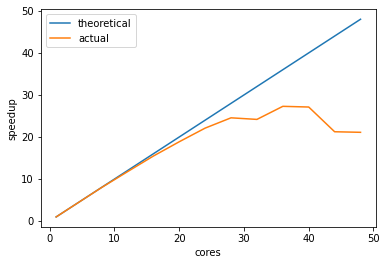

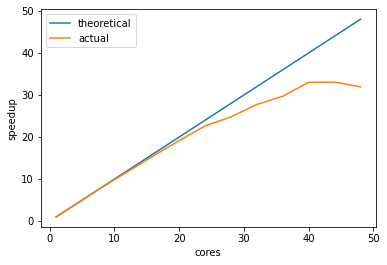

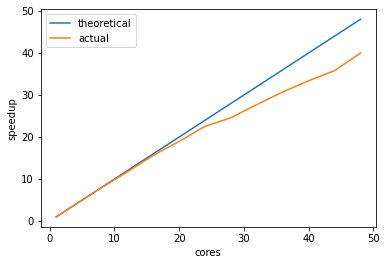

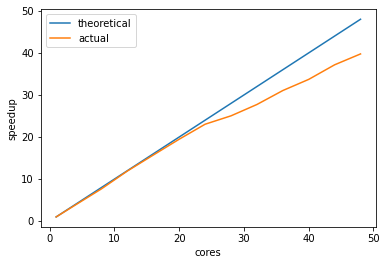

In [52]:
for exp, data in strong_tabs.items():
    arr = np.array(strong_tabs[exp][['GPU processors', 'avg']])
    arr[:,1] = arr[0, 1] / arr[:,1]

    fig, ax = plt.subplots()
    ax.plot(arr[:,0], arr)
    ax.set_xlabel("cores")
    ax.set_ylabel("speedup")
    ax.legend(['theoretical', 'actual'])

    plt.show()

### Weak